In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [2]:
import jax

jax.config.update("jax_compilation_cache_dir", "../jax-caches")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

from desc import set_device
set_device("gpu")

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [4]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import *
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import *
from desc.vmec_utils import *
from desc.input_reader import *
from desc.continuation import *

print_backend_info()

DESC version=0.14.2+166.g95db9f638.
Using JAX backend: jax version=0.6.0, jaxlib version=0.6.0, dtype=float64.
Using device: NVIDIA A100-PCIE-40GB (id=0), with 40.00 GB available memory.


In [75]:
eq = get("precise_QA")
eq.dim_x

1462

In [79]:
from desc.optimize.utils import compute_jac_scale

method = "direct1"
tconds = []
jconds = []
jscaleconds = []
jtconds = []
jtsconds = []
ress = np.arange(8, 17)
for res in ress:
    eq.change_resolution(L=res, M=res, N=res, L_grid=2*res, M_grid=2*res, N_grid=2*res)
    grid = ConcentricGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=eq.sym)
    transform = Transform(grid=grid, basis=eq.R_basis, method=method)
    if method in ["direct2"]:
        A = transform.matrices[method][0]
    elif method in ["fft"]:
        A = transform.matrices[method][0][0]
    else:
        A = transform.matrices[method][0][0][0]
    tcond = jnp.linalg.cond(A)
    tconds.append(tcond)
    P = jnp.concatenate([A, A], axis=0)
    Pinv = jnp.linalg.pinv(P)
    print(f"LMN={res:^4} {'F-Z transform':^30}  ===>  {tcond:.2e}")
    obj = ObjectiveFunction(ForceBalance(eq), jac_chunk_size=1)
    cons = get_fixed_boundary_constraints(eq)
    cons = maybe_add_self_consistency(eq, cons)
    con = ObjectiveFunction(cons)
    obj = LinearConstraintProjection(obj, con)
    obj.build(verbose=0)
    J = obj.jac_scaled_error(obj.x())
    scale, scale_inv = compute_jac_scale(J)
    Jcond = jnp.linalg.cond(J)
    Jscalecond = jnp.linalg.cond(J*scale)
    JTcond = jnp.linalg.cond(Pinv@J)
    scale2, _ = compute_jac_scale(Pinv@J)
    JTScond = jnp.linalg.cond(scale2*(Pinv@J))
    jtconds.append(JTcond)
    jtsconds.append(JTScond)
    jconds.append(Jcond)
    jscaleconds.append(Jscalecond)
    print(f"LMN={res:^4} {'Jacobian':^30}  ===>  {Jcond:.2e}")
    print(f"LMN={res:^4} {'Preconditioned Jacobian':^30}  ===>  {Jscalecond:.2e}")
    print(f"LMN={res:^4} {'Preconditioned Jacobian 2':^30}  ===>  {JTcond:.2e}")
    print(f"LMN={res:^4} {'Preconditioned Jacobian 3':^30}  ===>  {JTScond:.2e}")
    del J, A

LMN= 8           F-Z transform           ===>  7.10e+00
LMN= 8              Jacobian             ===>  3.87e+07
LMN= 8      Preconditioned Jacobian      ===>  5.27e+06
LMN= 8     Preconditioned Jacobian 2     ===>  7.84e+03
LMN= 8     Preconditioned Jacobian 3     ===>  6.92e+02
LMN= 9           F-Z transform           ===>  7.53e+00
LMN= 9              Jacobian             ===>  2.55e+08
LMN= 9      Preconditioned Jacobian      ===>  4.10e+07
LMN= 9     Preconditioned Jacobian 2     ===>  5.07e+03
LMN= 9     Preconditioned Jacobian 3     ===>  9.67e+02
LMN= 10          F-Z transform           ===>  7.99e+00
LMN= 10             Jacobian             ===>  2.18e+09
LMN= 10     Preconditioned Jacobian      ===>  2.57e+08
LMN= 10    Preconditioned Jacobian 2     ===>  1.19e+04
LMN= 10    Preconditioned Jacobian 3     ===>  1.10e+03
LMN= 11          F-Z transform           ===>  8.46e+00
LMN= 11             Jacobian             ===>  6.26e+09
LMN= 11     Preconditioned Jacobian      ===>  7

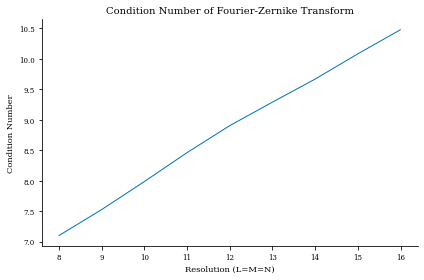

In [80]:
plt.plot(ress, tconds)
plt.xlabel("Resolution (L=M=N)")
plt.ylabel("Condition Number")
plt.title("Condition Number of Fourier-Zernike Transform")
plt.savefig("fz-transform-condition-number.png", dpi=400)

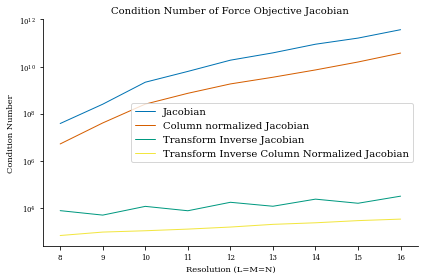

In [81]:
plt.semilogy(ress, jconds, label="Jacobian")
plt.semilogy(ress, jscaleconds, label="Column normalized Jacobian")
plt.semilogy(ress, jtconds, label="Transform Inverse Jacobian")
plt.semilogy(ress, jtsconds, label="Transform Inverse Column Normalized Jacobian")
plt.legend()
plt.xlabel("Resolution (L=M=N)")
plt.ylabel("Condition Number")
plt.title("Condition Number of Force Objective Jacobian")
plt.savefig("jacobian-condition-number.png", dpi=400)

In [71]:
eq = get("W7-X")
# res = 8
# eq.change_resolution(L=res, M=res, N=res, L_grid=2*res, M_grid=2*res, N_grid=2*res)
grid = ConcentricGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=eq.sym)
transformR = Transform(grid=grid, basis=eq.R_basis, method=method)
transformZ = Transform(grid=grid, basis=eq.Z_basis, method=method)
transformL = Transform(grid=grid, basis=eq.L_basis, method=method)
A = transformR.matrices[method][0][0][0]
B = transformZ.matrices[method][0][0][0]
C = transformL.matrices[method][0][0][0]
obj = ObjectiveFunction(ForceBalance(eq), jac_chunk_size=1)
cons = get_fixed_boundary_constraints(eq)
cons = maybe_add_self_consistency(eq, cons)
con = ObjectiveFunction(cons)
obj = LinearConstraintProjection(obj, con)
obj.build(verbose=0)
J = obj.jac_scaled_error(obj.x())

In [72]:
# P = jnp.concatenate([A, B], axis=1)
# P = jnp.block([[A, jnp.zeros((A.shape[0], B.shape[1]))], [jnp.zeros((B.shape[0], A.shape[1])), B]])
P = jnp.concatenate([A, A], axis=0)

In [73]:
P.shape, J.shape

((5346, 1141), (5346, 2784))

In [74]:
Pinv = jnp.linalg.pinv(P)
cond1 = jnp.linalg.cond(Pinv)
cond2 = jnp.linalg.cond(Pinv@J)
cond3 = jnp.linalg.cond(J)
cond1, cond2, cond3

(Array(9.0494, dtype=float64),
 Array(3363.6827, dtype=float64),
 Array(1542731.3698, dtype=float64))

In [67]:
obj.objectives[0].constants["transforms"]["R"]

Transform at 0x15407f7a8da0 (method=fft, basis=FourierZernikeBasis at 0x1540800b22d0 (L=24, M=12, N=3, NFP=19, sym=cos, spectral_indexing=fringe), grid=ConcentricGrid at 0x1540b883a630 (L=36, M=18, N=6, NFP=19, sym=True, is_meshgrid=False, node_pattern=jacobi, coordinates=rtz))